<a href="https://colab.research.google.com/github/chetan015/ganex/blob/main/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Wasserstein GAN with Gradient Penalty**
WGAN-GP solves some of the stability issues with DCGAN. Using the earth mover distance in place of KL divergenece for the loss function, prevents vanishing gradients and mode collapse. The discriminator that classifies fake and real as 0 and 1 is now replaced with a critic that scores images with real numbers.


In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [6]:
  class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

Training Initializations


*  n_epochs: the number of times you iterate through the entire dataset when training
*  z_dim: the dimension of the noise vector
*  display_step: how often to display/visualize the images
*  batch_size: the number of images per forward/backward pass
*  lr: the learning rate
*  beta_1, beta_2: the momentum terms
*  c_lambda: weight of the gradient penalty
*  crit_repeats: number of times to update the critic per generator update
*  device: the device type


In [7]:
n_epochs = 100
z_dim = 64
display_step = 50
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [8]:
gen = Generator(z_dim).to(device)
print(gen)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))
print(crit)
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)
Critic(
  (crit): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

**Gradient Penalty**
Calculating the gradient penalty can be broken into two functions: (1) compute the gradient with respect to the images and (2) compute the gradient penalty given the gradient.

In [9]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        inputs=mixed_images,
        outputs=mixed_scores,
        # These other parameters have to do with how the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [10]:
# UNIT TEST
def test_get_gradient(image_shape):
    real = torch.randn(*image_shape, device=device) + 1
    fake = torch.randn(*image_shape, device=device) - 1
    epsilon_shape = [1 for _ in image_shape]
    epsilon_shape[0] = image_shape[0]
    epsilon = torch.rand(epsilon_shape, device=device).requires_grad_()
    gradient = get_gradient(crit, real, fake, epsilon)
    assert tuple(gradient.shape) == image_shape
    assert gradient.max() > 0
    assert gradient.min() < 0
    return gradient

gradient = test_get_gradient((256, 1, 28, 28))
print("Success!")

Success!


In [13]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm-1)**2)
    #### END CODE HERE ####
    return penalty

In [14]:
# UNIT TEST
def test_gradient_penalty(image_shape):
    bad_gradient = torch.zeros(*image_shape)
    bad_gradient_penalty = gradient_penalty(bad_gradient)
    assert torch.isclose(bad_gradient_penalty, torch.tensor(1.))

    image_size = torch.prod(torch.Tensor(image_shape[1:]))
    good_gradient = torch.ones(*image_shape) / torch.sqrt(image_size)
    good_gradient_penalty = gradient_penalty(good_gradient)
    assert torch.isclose(good_gradient_penalty, torch.tensor(0.))

    random_gradient = test_get_gradient(image_shape)
    random_gradient_penalty = gradient_penalty(random_gradient)
    assert torch.abs(random_gradient_penalty - 1) < 0.1

test_gradient_penalty((256, 1, 28, 28))
print("Success!")


Success!


**Losses**

For the generator, the loss is calculated by maximizing the critic's prediction on the generator's fake images. The argument has the scores for all fake images in the batch, but you will use the mean of them.

In [17]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    gen_loss = -1 * torch.mean(crit_fake_pred)
    return gen_loss

In [18]:
# UNIT TEST
assert torch.isclose(
    get_gen_loss(torch.tensor(1.)),
    torch.tensor(-1.0)
)
print("Success!")

Success!


For the critic, the loss is calculated by maximizing the distance between the critic's predictions on the real images and the predictions on the fake images while also adding a gradient penalty. The gradient penalty is weighed according to lambda. The arguments are the scores for all the images in the batch, and you will use the mean of them.

In [21]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''

    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda*gp
    return crit_loss

In [22]:
# UNIT TEST
assert torch.isclose(
    get_crit_loss(torch.tensor(1.), torch.tensor(2.), torch.tensor(3.), 0.1),
    torch.tensor(-0.7)
)
assert torch.isclose(
    get_crit_loss(torch.tensor(20.), torch.tensor(-20.), torch.tensor(2.), 10),
    torch.tensor(60.)
)

print("Success!")

Success!


1. Even on GPU, the training will run more slowly 
than when using BCEloss because the gradient penalty requires you to compute the gradient of a gradient -- this means potentially a few minutes per epoch! For best results, run this for as long as you can while on GPU.
2. One important difference from earlier versions is that you will update the critic multiple times every time you update the generator This helps prevent the generator from overpowering the critic. Sometimes, you might see the reverse, with the generator updated more times than the critic. This depends on architectural (e.g. the depth and width of the network) and algorithmic choices (e.g. which loss you're using).
3. WGAN-GP isn't necessarily meant to improve overall performance of a GAN, but just increases stability and avoids mode collapse. In general, a WGAN will be able to train in a much more stable way than the vanilla DCGAN, though it will generally run a bit slower. You should also be able to train the model for more epochs without it collapsing.

Step 50: Generator loss: -0.18003673996776343, critic loss: 2.2580945949554447


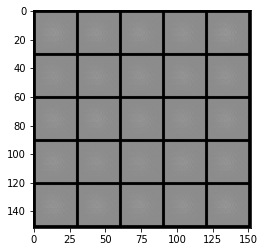

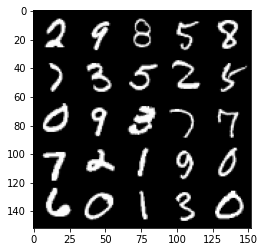

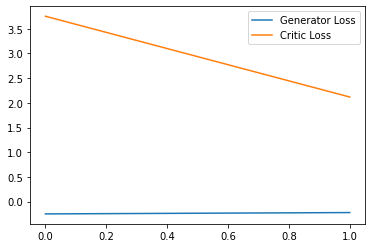

Step 100: Generator loss: 0.8363162718713284, critic loss: -1.4063533216714859


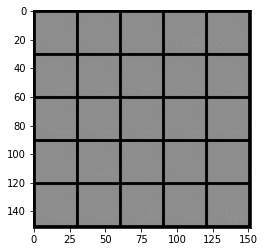

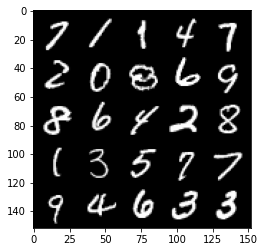

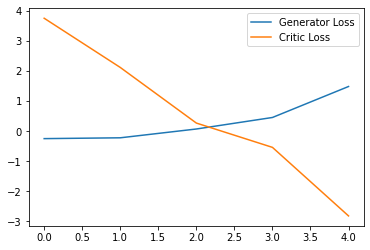

Step 150: Generator loss: 2.757270677089691, critic loss: -10.188146640777589


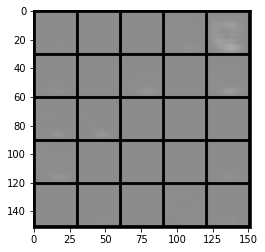

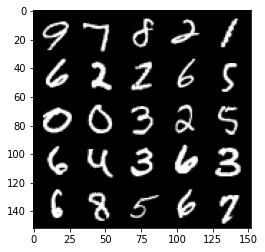

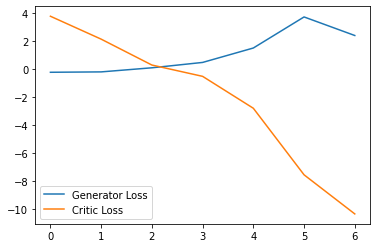

Step 200: Generator loss: 2.2483753299713136, critic loss: -29.255686252593986


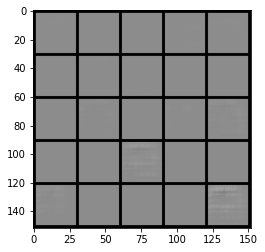

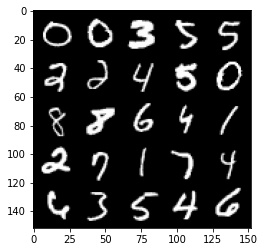

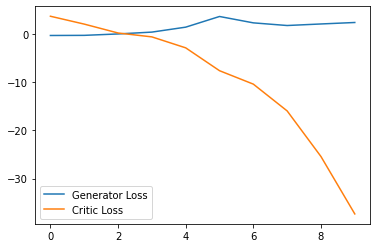

Step 250: Generator loss: 0.7555256628990173, critic loss: -66.13315783691405


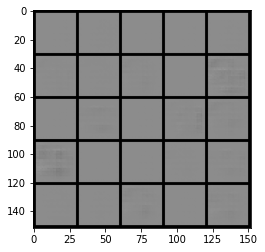

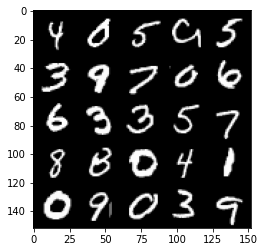

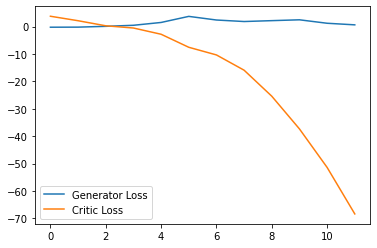

Step 300: Generator loss: -0.6893188917636871, critic loss: -120.13616516113284


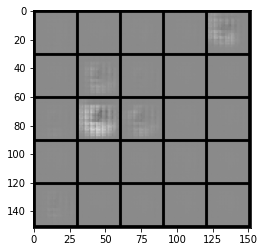

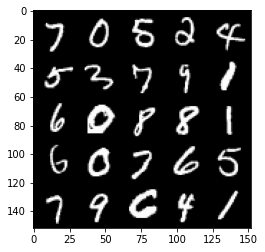

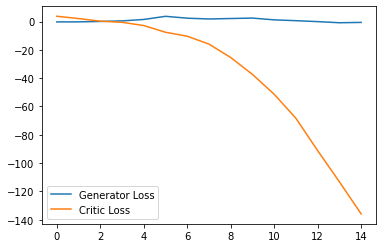

Step 350: Generator loss: -2.6853032422065737, critic loss: -181.82996014404293


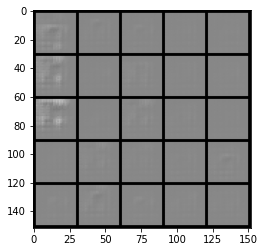

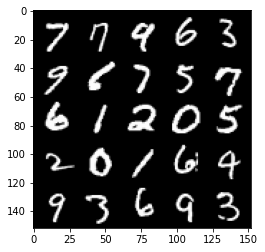

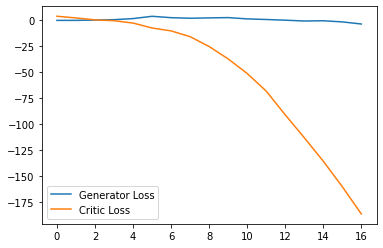

Step 400: Generator loss: -1.232983735501766, critic loss: -250.69854125976565


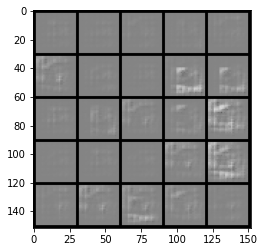

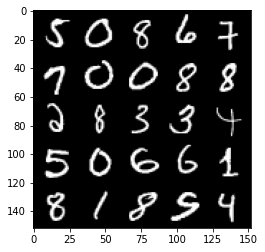

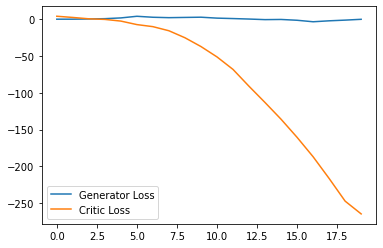

Step 450: Generator loss: -11.056398643553257, critic loss: -279.58020462036126


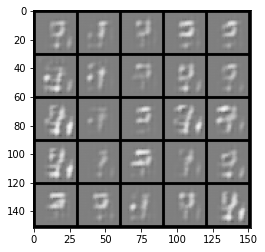

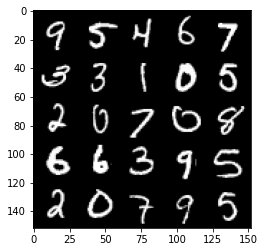

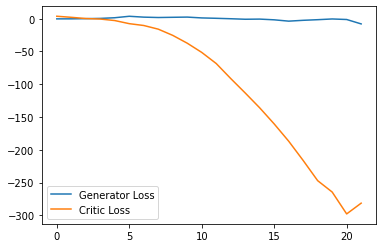

Step 500: Generator loss: 3.873701872229576, critic loss: -345.7031567382812


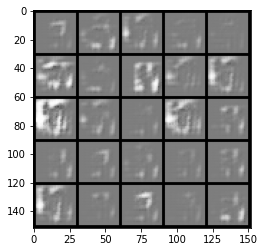

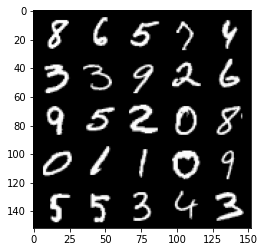

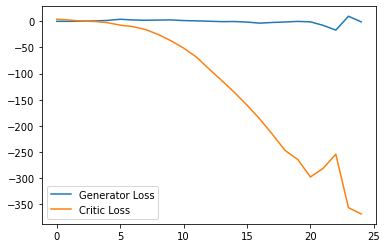

Step 550: Generator loss: -7.127702083885669, critic loss: -410.20933050537104


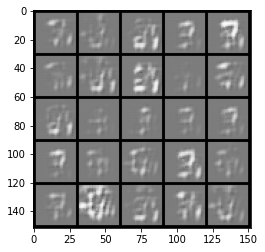

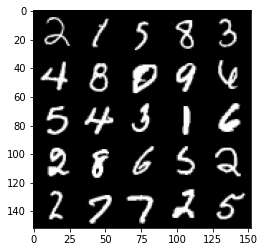

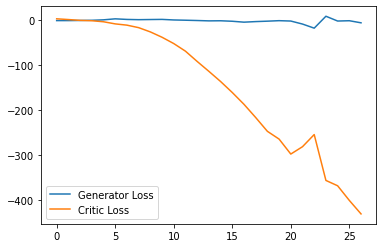

Step 600: Generator loss: -3.8352335441112517, critic loss: -456.20346859741227


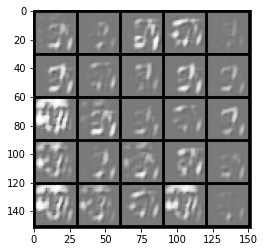

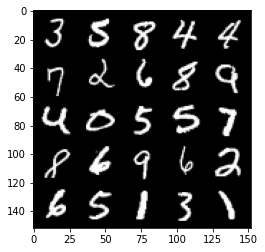

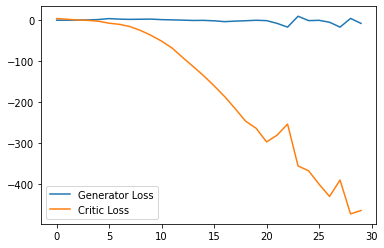

Step 650: Generator loss: -3.3368125438690184, critic loss: -516.5849554443358


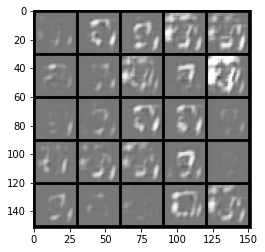

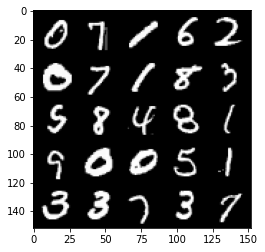

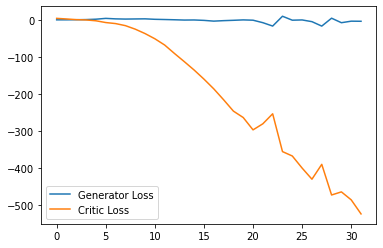

Step 700: Generator loss: -52.271354594528674, critic loss: -426.92626528930674


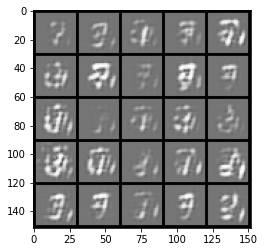

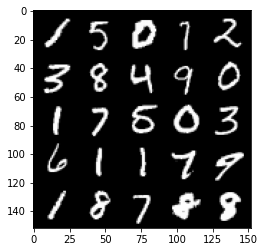

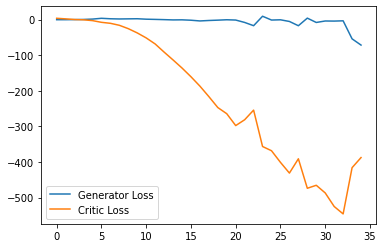

Step 750: Generator loss: -15.479154257774352, critic loss: -501.38294741821306


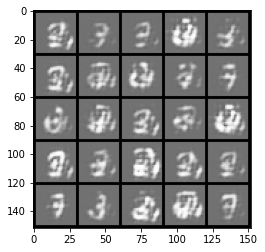

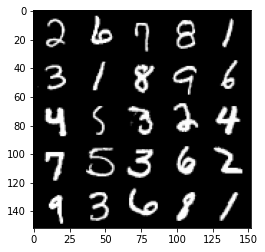

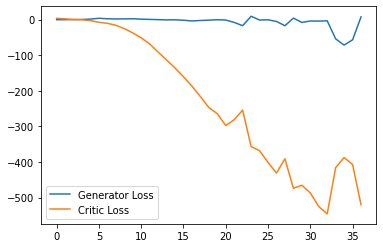

Step 800: Generator loss: 1.9887251305580138, critic loss: -597.3712579956054


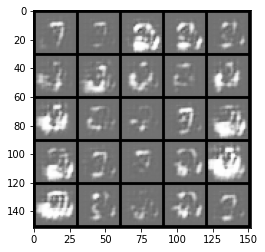

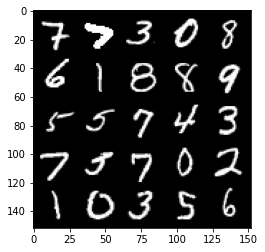

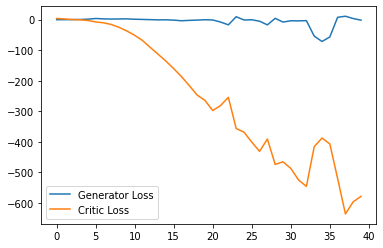

Step 850: Generator loss: 6.186629467010498, critic loss: -613.9046782226563


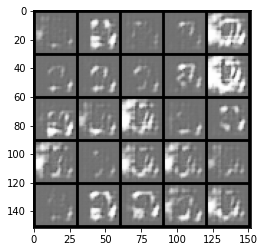

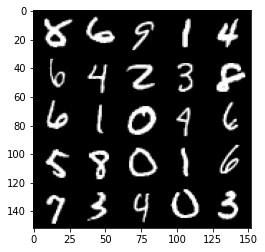

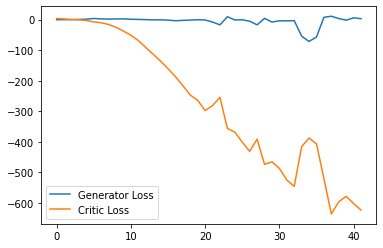

Step 900: Generator loss: 0.16713834285736084, critic loss: -598.0512341308593


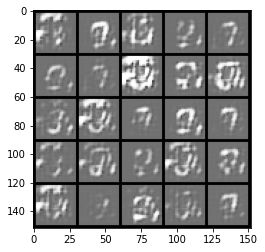

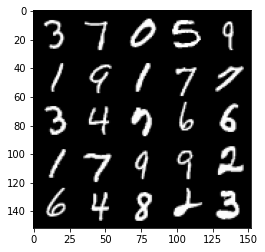

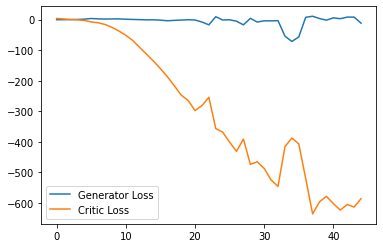

Step 950: Generator loss: 13.942259395122528, critic loss: -669.0242178955076


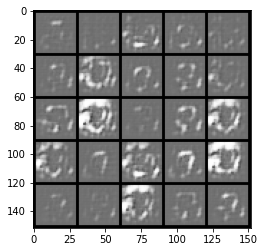

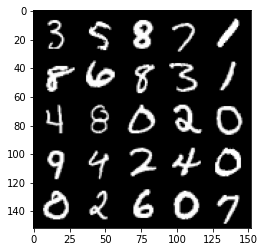

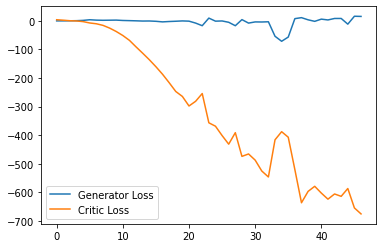

Step 1000: Generator loss: -21.4910324883461, critic loss: -572.0850057373046


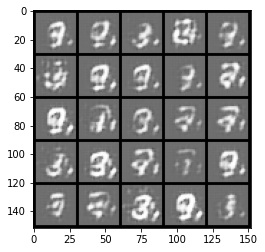

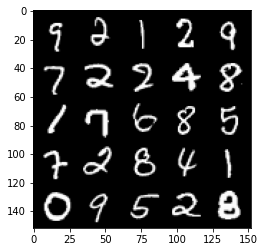

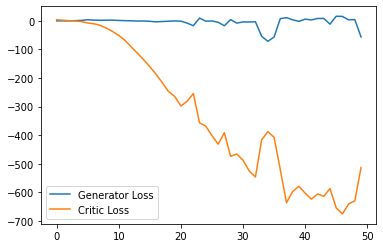

Step 1050: Generator loss: 28.000479497909545, critic loss: -716.567216674805


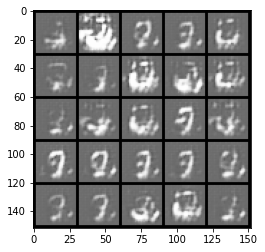

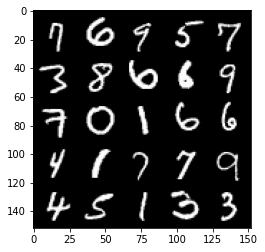

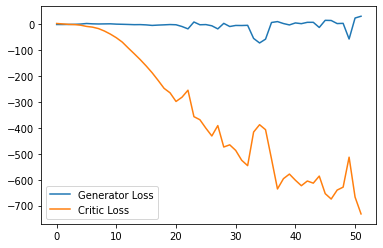

Step 1100: Generator loss: 21.660885200500488, critic loss: -723.6303706054689


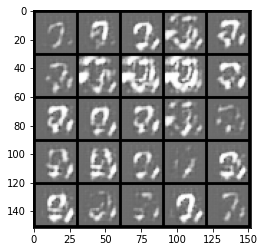

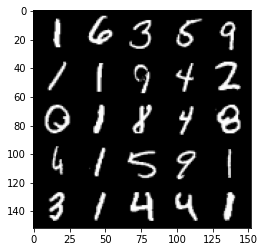

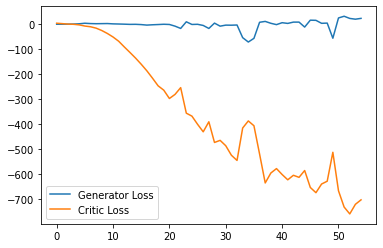

Step 1150: Generator loss: 23.04068950653076, critic loss: -692.5579951782227


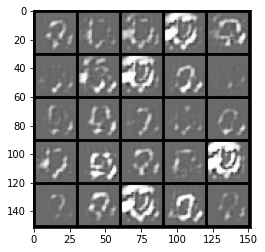

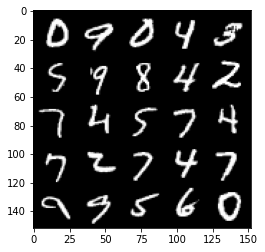

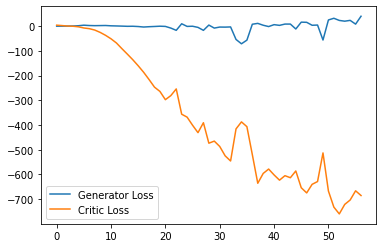

Step 1200: Generator loss: 24.8002649974823, critic loss: -743.9297304687501


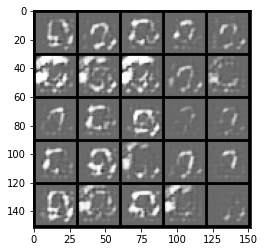

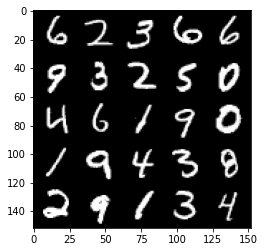

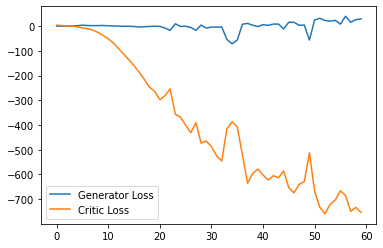

Step 1250: Generator loss: 27.553407535552978, critic loss: -780.1102421874999


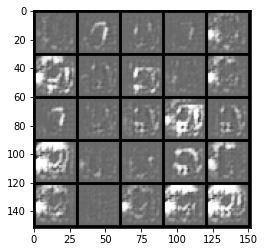

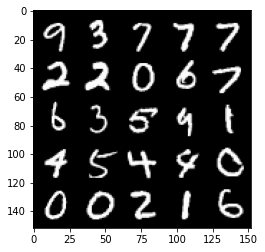

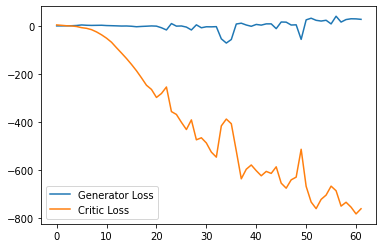

Step 1300: Generator loss: 17.330472660064697, critic loss: -785.27681640625


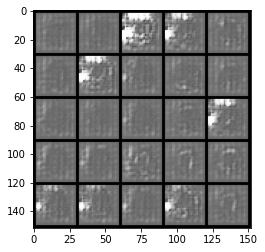

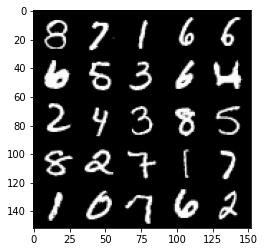

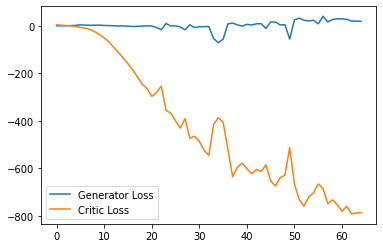

Step 1350: Generator loss: 23.790908846855164, critic loss: -820.385806640625


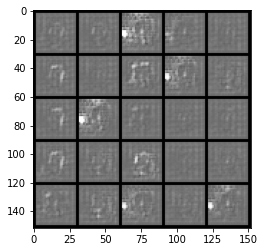

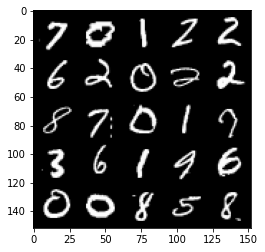

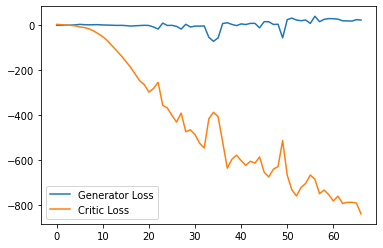

Step 1400: Generator loss: 20.65502238035202, critic loss: -837.7816047363282


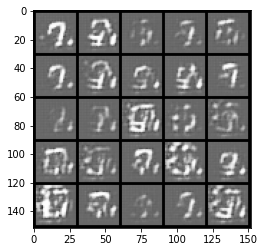

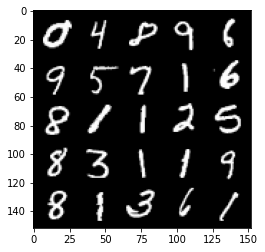

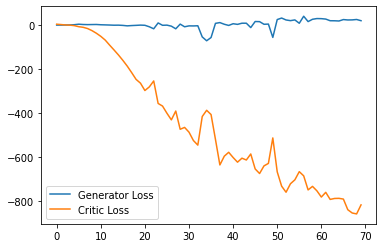

Step 1450: Generator loss: -6.09403715133667, critic loss: -652.3669079589843


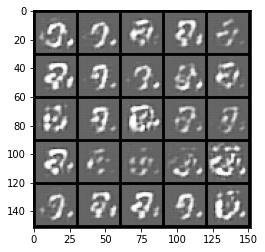

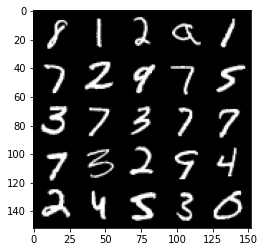

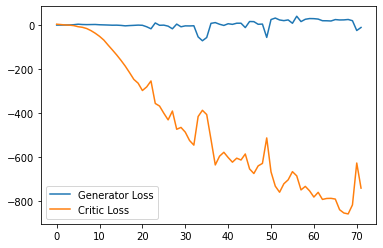

Step 1500: Generator loss: -42.714151029586795, critic loss: -497.5243864593507


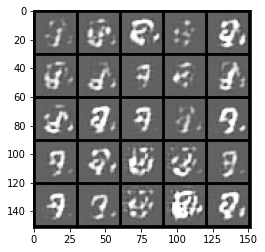

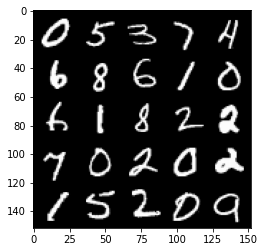

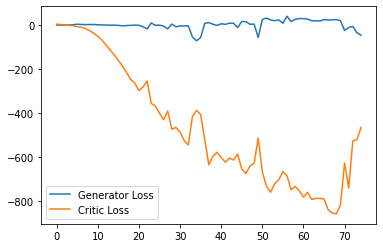

Step 1550: Generator loss: -49.83260893821716, critic loss: -589.9921110534668


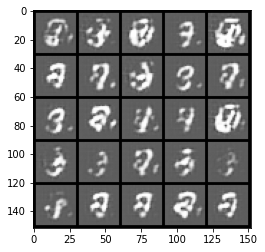

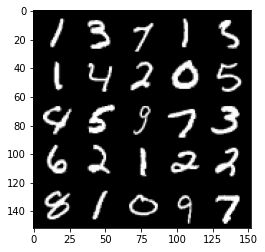

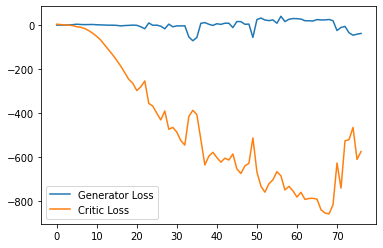

Step 1600: Generator loss: -32.49562238931656, critic loss: -598.3236445922853


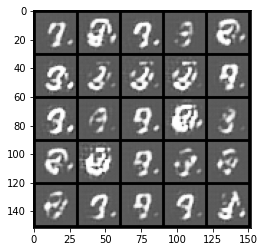

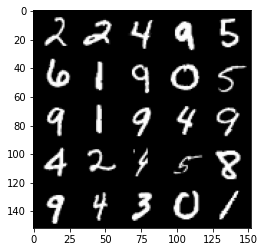

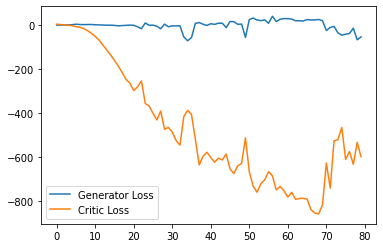

Step 1650: Generator loss: 7.203284111022949, critic loss: -634.1196067199706


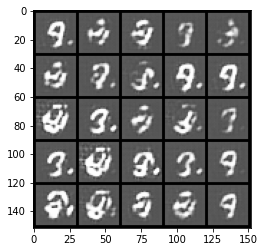

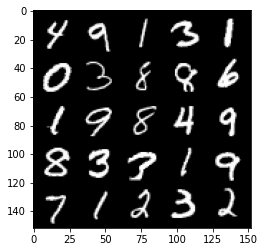

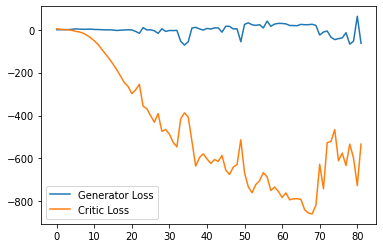

Step 1700: Generator loss: 11.979789938926697, critic loss: -611.0941973876954


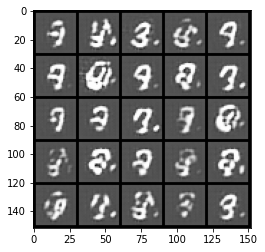

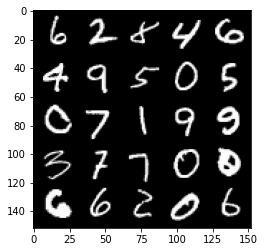

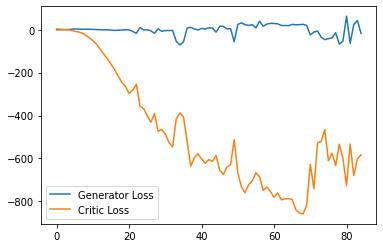

Step 1750: Generator loss: 58.684974339008335, critic loss: -728.3366264648437


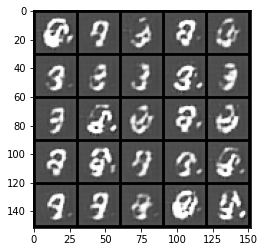

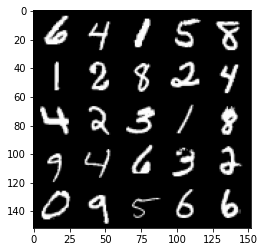

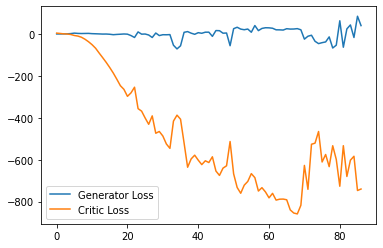

Step 1800: Generator loss: 22.571205172538757, critic loss: -657.6718564453124


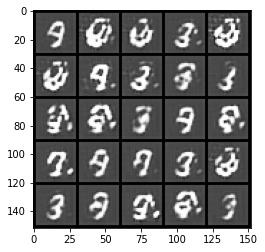

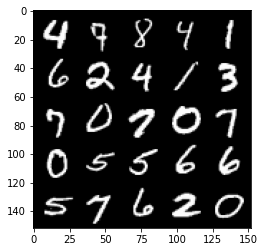

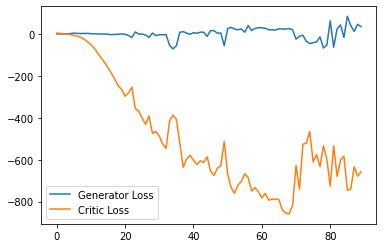

Step 1850: Generator loss: -24.47955598652363, critic loss: -525.0260599365236


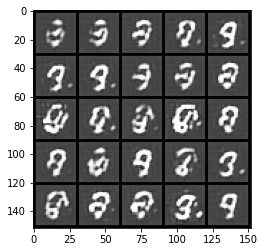

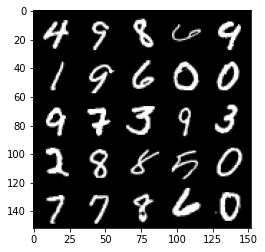

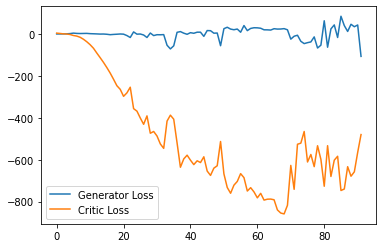

Step 1900: Generator loss: 19.48248560667038, critic loss: -515.6075926818847


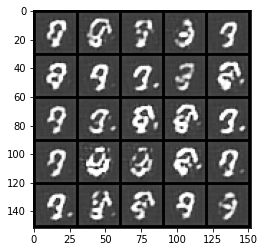

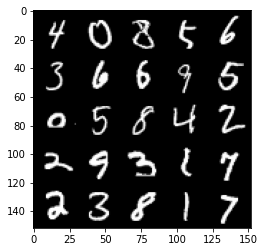

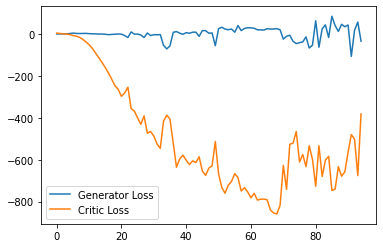

Step 1950: Generator loss: 3.8810402965545654, critic loss: -400.97825263977035


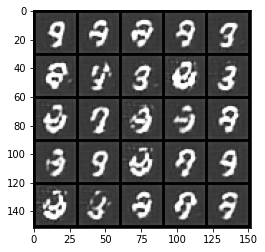

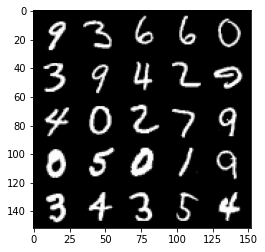

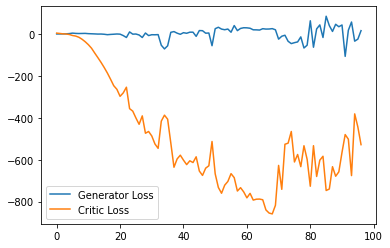

Step 2000: Generator loss: 68.08223480224609, critic loss: 45.82828504943849


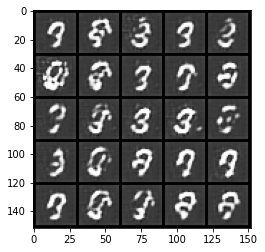

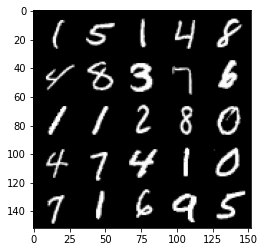

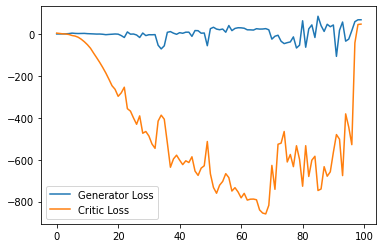

Step 2050: Generator loss: 67.37392402648926, critic loss: 27.476832534790045


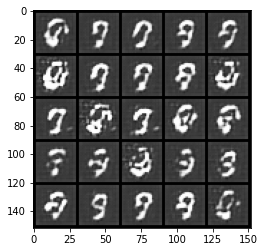

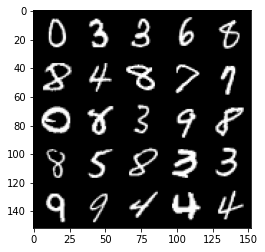

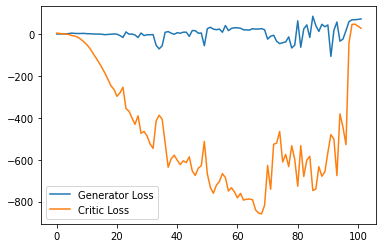

Step 2100: Generator loss: 2.4093131542205812, critic loss: -148.99764630126955


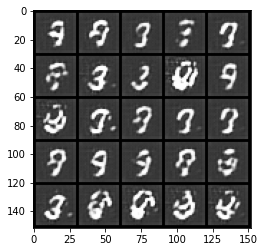

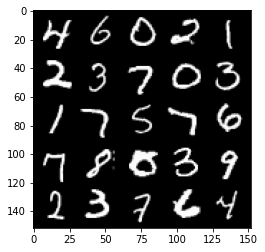

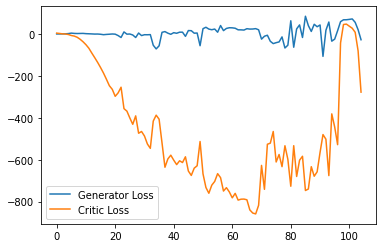

Step 2150: Generator loss: 32.30318290710449, critic loss: -135.83174219512938


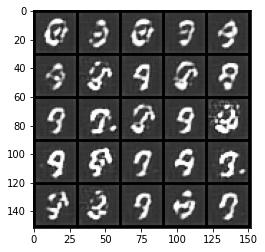

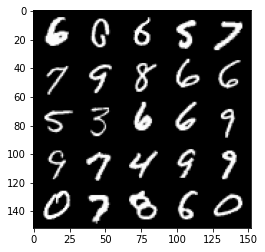

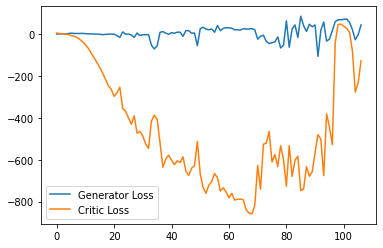

Step 2200: Generator loss: 52.231418190002444, critic loss: -41.27122798919676


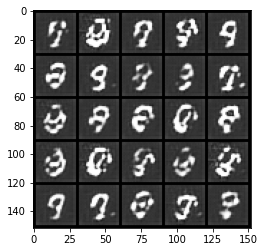

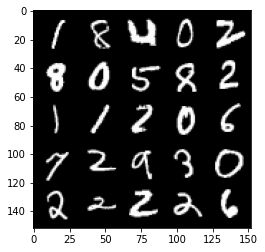

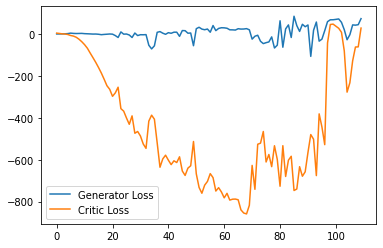

Step 2250: Generator loss: 77.76570028305053, critic loss: 2.870621696472166


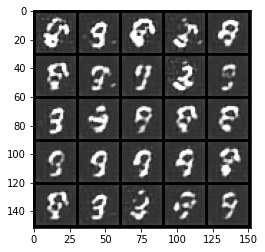

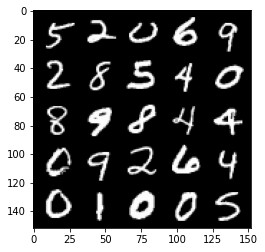

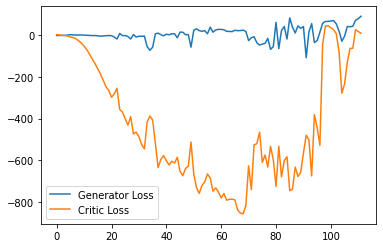

Step 2300: Generator loss: -22.8698512339592, critic loss: -199.23874412536617


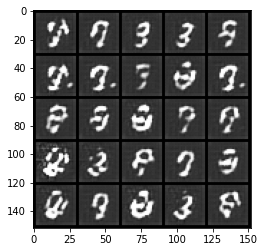

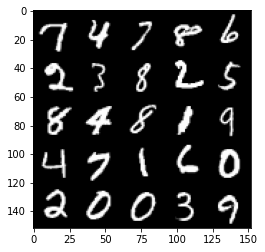

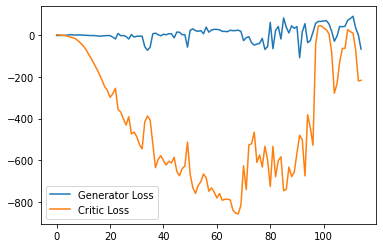

Step 2350: Generator loss: -1.3088071060180664, critic loss: -199.7721369628906


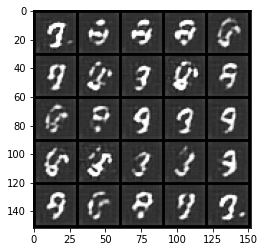

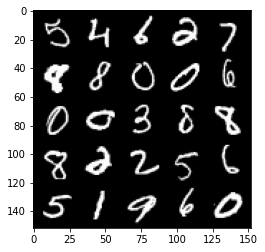

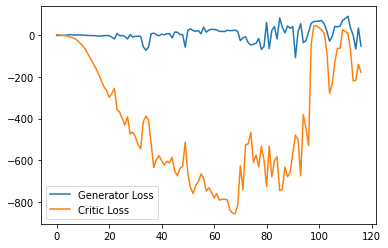

Step 2400: Generator loss: -73.1216927266121, critic loss: -208.4115309753418


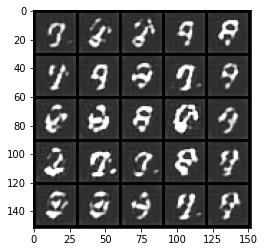

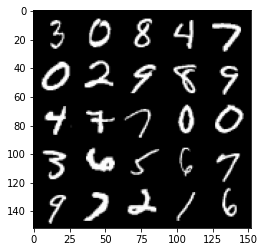

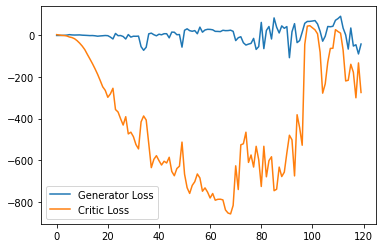

Step 2450: Generator loss: 24.553986067771913, critic loss: -53.1761325073242


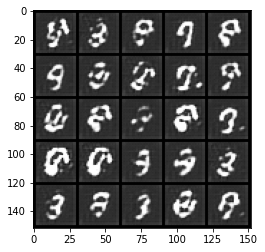

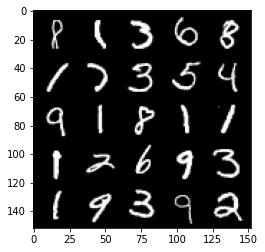

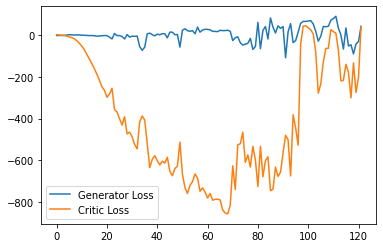

Step 2500: Generator loss: 80.1787062072754, critic loss: 3.119916732788087


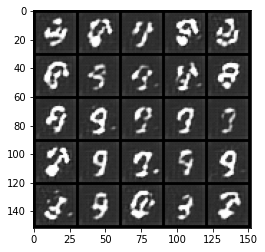

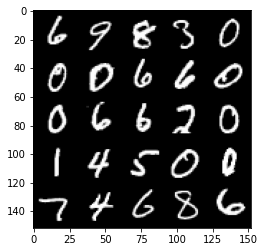

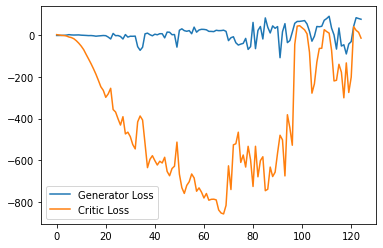

Step 2550: Generator loss: -6.359580132961273, critic loss: -113.12530307006837


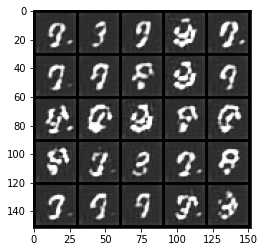

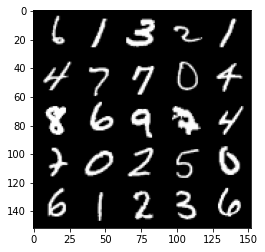

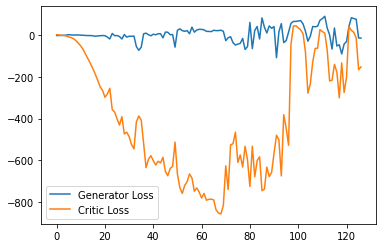

Step 2600: Generator loss: 91.64099411010743, critic loss: 8.136465591430662


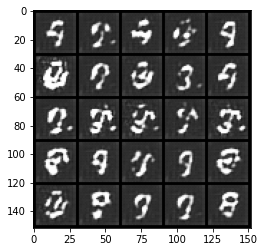

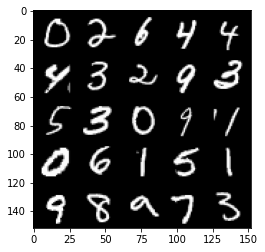

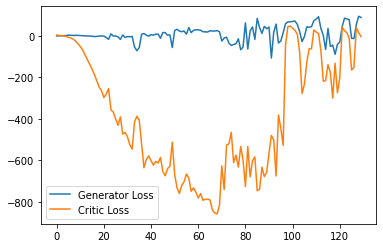

Step 2650: Generator loss: 25.304308758974074, critic loss: -137.79420031738283


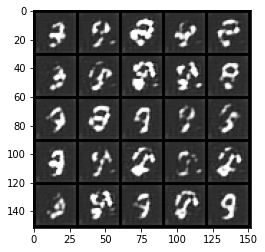

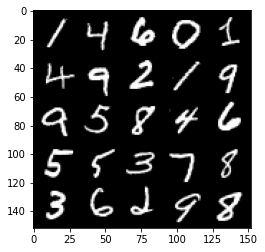

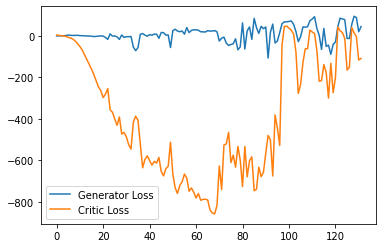

Step 2700: Generator loss: -29.77005355834961, critic loss: -178.30776603698723


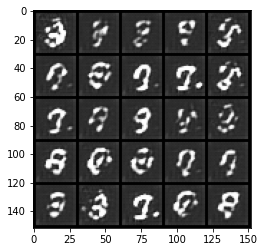

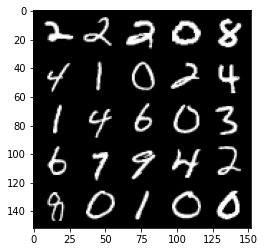

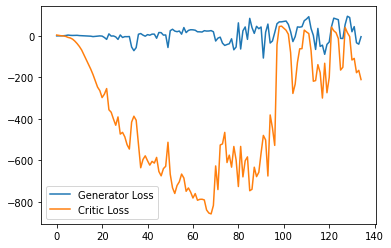

Step 2750: Generator loss: 58.054327983856204, critic loss: -113.8054705963135


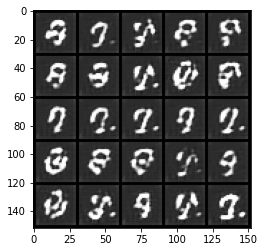

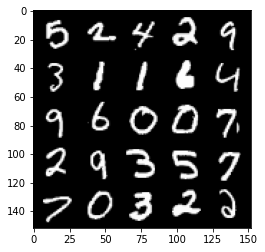

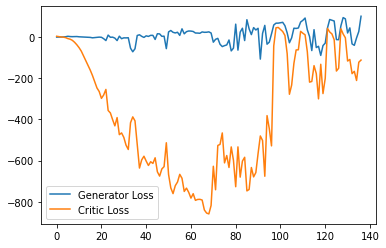

In [ ]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1